In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enchant.utils import levenshtein

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

## Q :Ecrire un notebook jupyter qui met en évidence les problèmes de qualité de données (données incohérentes, données manquantes etc.)

#### Données absentes pour chaque colonne

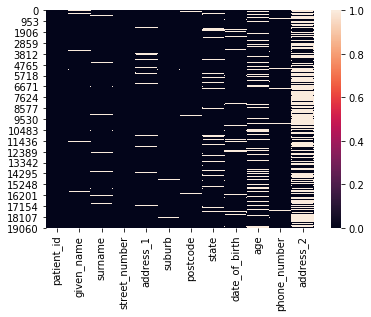

patient_id           0
given_name         440
surname            425
street_number      382
address_1          796
suburb             212
postcode           199
state             1990
date_of_birth     2011
age               3997
phone_number       919
address_2        12107
dtype: int64

In [2]:
sns.heatmap(df_patient.isna())
plt.show()

df_patient.isna().sum()

#### Types des colonnes : beaucoup de type 'object'. Les types des colonnes pourraient être plus précis : 
street number, postcode, age en int <br/>
date_of_birth en format date au lieu de float

In [3]:
print(df_patient.dtypes)
df_patient.head(2)

patient_id         int64
given_name        object
surname           object
street_number    float64
address_1         object
suburb            object
postcode          object
state             object
date_of_birth    float64
age              float64
phone_number      object
address_2         object
dtype: object


,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown


In [4]:
age_isint = df_patient.age.fillna(0).map(lambda x: int(x) - x == 0)

# au cas où l'âge serait effectivement en float, 21.5 ans par exemple
print("{} % des âges mentionnés sont des entiers".format(sum(age_isint) / len(df_patient) * 100))

100.0 % des âges mentionnés sont des entiers


#### Pour une étude statistique, il y a un manque de données pour les personnes entre 16 et 19 ans (approximativement)

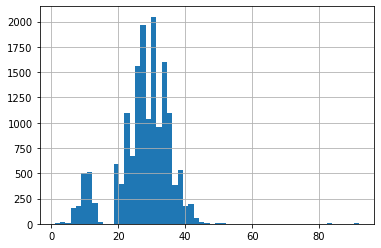

In [5]:
age = df_patient.age.fillna(0).astype(int)
age[age != 0].hist(bins=age.nunique() - 1)

### Histoire de déduction : l'information est là mais la donnée ne l'est pas
Il y a des gens pour qui l'âge pourrait se déduire de la date de naissance mais est absente, même si l'année de naissance est parfois douteuse (index 19977 ci-dessous, né en 1901 ?). Il pourrait y avoir des typos dans la date de naissance.

In [6]:
df_patient[(~df_patient.date_of_birth.isna()) & (df_patient.age.isna())][["date_of_birth","age"]]

,date_of_birth,age
14,19810810.0,NaN
18,19070704.0,NaN
30,19871005.0,NaN
32,19181231.0,NaN
33,19471129.0,NaN
...,...,...
19974,19381109.0,NaN
19977,19010116.0,NaN
19978,19470923.0,NaN
19981,19730511.0,NaN


#### Un autre cas de déduction possible. En connaissant le numéro de rue et l'adresse, on peut trouver les autres éléments manquants 'suburb','postcode','state' qui encadrent le lieu exact.

In [7]:
precise_location = ~df_patient.street_number.isna() & ~df_patient.address_1.isna()
greater_location = df_patient.suburb.isna() | df_patient.postcode.isna()

df_patient[precise_location & greater_location][df_patient.columns[3:8]]

,street_number,address_1,suburb,postcode,state
18,30.0,elsey street,None,3109,qld
95,12.0,newman morris circuit,coombabah,None,vic
121,5.0,bainton crescent,None,3289,vic
144,78.0,catani place,thornlie,None,nsw
161,22.0,kenyon circuit,brooweena,None,nsw
...,...,...,...,...,...
19819,18.0,newman morris circuit,None,4506,nsw
19823,3.0,parker street,ngunnawal,None,None
19893,123.0,morrell place,None,5083,nsw
19937,24.0,namatjira drive,None,2821,vic


Tentative ratée : deviner le 'state' à partir de 'suburb' ou 'postcode'. Les 2 ne donnent pas le même 'state' le plus fréquent et lorsqu'ils s'accordent, une recherche google dit que ce n'est pas le bon 'state'.

In [8]:
df_patient[(df_patient.state.isna()) & (~df_patient.suburb.isna())]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
21,818315,ruby,grafton,97.0,dannevig place,st clair,3180,None,19180714.0,23.0,02 12194238,glenwarren
28,314176,talia,mitton,10.0,starling place,broken hill,2117,None,19520229.0,8.0,07 43440041,alexander's folly
36,970910,tabitha,friman,8.0,howitt street,bulimba,2800,None,19070513.0,40.0,07 30294882,None
38,249503,lucas,katsiavos,20.0,shakespeare crescent,nightcliff,4655,None,19921005.0,NaN,02 58639506,kangaroo grnd
45,184654,bailey,vanlaatum,NaN,mckail crescent,birtinya,3130,None,19370819.0,39.0,04 35418868,None
...,...,...,...,...,...,...,...,...,...,...,...,...
19952,916593,matthew,wht,NaN,altson circuit,midvale,3204,None,19120978.0,NaN,07 93690529,None
19956,770095,alexia,bridgland,18.0,harrison street,lismore,2020,None,NaN,NaN,07 09296938,None
19957,159919,zachary,mccarthy,28.0,None,greenacre,6027,None,19260810.0,23.0,08 10488162,None
19972,144588,jamie,chandler,128.0,rosman circuit,whitfield,3355,None,19051211.0,42.0,08 53766398,the willows


2e LIGNE du dessus : Plus fréquent 'state' pour le suburb 'broken hill' est NSW

In [9]:
df_patient[df_patient.suburb=='broken hill'].state.value_counts()

vic     16
nsw     16
qld      8
wa       5
tas      5
sa       3
act      2
nsxw     1
nt       1
ta       1
Name: state, dtype: int64

2e LIGNE du dessus: Plus fréquent 'state' pour le postcode '2117' est WA. NSW en 3e position. La géographie est incohérente.

In [10]:
df_patient[df_patient.postcode=='2117'].state.value_counts()

wa     5
vic    5
nsw    4
qld    3
sa     2
Name: state, dtype: int64

Il n'y a pas 100 'state' en Australie, il y en a 8. Typos !

In [11]:
df_patient.state.value_counts()

nsw     6143
vic     4352
qld     3516
wa      1580
sa      1391
        ... 
nze        1
tab        1
ng         1
nswt       1
taz        1
Name: state, Length: 102, dtype: int64

Le 'suburb' et le 'postcode' peuvent être inversés.

In [12]:
df_patient[df_patient.suburb == '3020']

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None


#### Il n'y a pas de date du test pcr. La colonne de pcr n'est pas encodée de manière uniforme (N ou Negative, P ou Positive).

In [13]:
df_pcr.head(8)

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative
5,876796,N
6,169224,Negative
7,755915,P


Des doublons. Il peut s'agir d'erreurs de frappes/logiciel ou de tests à des moments différents.

In [14]:
print("Nombre de doublons dans la dataframe pcr : ", len(df_pcr) - len(df_pcr.drop_duplicates()))
print("Nombre de doublons de patient_id dans la dataframe pcr :", len(df_pcr) - len(df_pcr.drop_duplicates(subset="patient_id")))

Nombre de doublons dans la dataframe pcr :  14
Nombre de doublons de patient_id dans la dataframe pcr : 35


### Incohérences

#### Des patient_id ne correspondent pas à la même personne.

In [15]:
df_patient[df_patient.patient_id == 119816]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
1456,119816,jed,rollins,63.0,mauldon street,macquarie fields,4169,nsw,19010805.0,NaN,07 73786737,None
2377,119816,sam,iasenzaniro,12.0,booroondara street,brighton,6153,sa,19621207.0,NaN,03 90915909,None


#### Il y a des erreurs dans la date de naissance ou l'âge. OU le dataset a réuni des cas d'autrefois mais c'est improbable puisque l'exercice porte sur des personnes ayant fait un test PCR cette année. 

Ci-dessous la 1ère ligne dit qu'une personne née en 1992 aurait 40 ans, ce qui reviendrait à dire que nous sommes actuellement en 2032.

In [16]:
birth_age = df_patient.loc[(~df_patient.date_of_birth.isna()) & (~df_patient.age.isna()), ["date_of_birth", "age"]]
birth_age["ref_year"] = (birth_age.date_of_birth // 10000 + birth_age.age).astype(int)
birth_age[(birth_age.ref_year < 1900) | (birth_age.ref_year > 2020)]

,date_of_birth,age,ref_year
16,19920702.0,40.0,2032
41,19970807.0,31.0,2028
44,19821125.0,42.0,2024
46,19990716.0,30.0,2029
52,19920110.0,30.0,2022
...,...,...,...
19871,19970218.0,30.0,2027
19889,19920811.0,33.0,2025
19902,19991003.0,32.0,2031
19930,19980718.0,30.0,2028


#### Un suburb ne peut appartenir à plusieurs régions

In [17]:
df_patient[df_patient.suburb=='bulimba'].state.value_counts()

nsw    3
vic    3
qld    3
Name: state, dtype: int64

Pas de problème grossier pour les numéros de téléphone.

In [18]:
# 2 premiers chiffres du numéro de téléphone
df_patient.phone_number.dropna().map(lambda x: x[:2]).value_counts()

04    3915
03    3887
08    3835
02    3733
07    3711
Name: phone_number, dtype: int64

In [19]:
# Longueur OK
df_patient.phone_number.dropna().map(lambda x: len(x)).value_counts()

11    19081
Name: phone_number, dtype: int64

In [20]:
def all_numbers(phone_number):
    '''Check if ONE phone number is composed of numbers only, excluding the space'''
    number = phone_number.replace(" ", "")
    return sum(list(map(lambda x: ord('0') <= ord(x) & ord(x) <= ord('9') , number))) == len(number)

In [21]:
# Tous sont composés de chiffres uniquement, en excluant l'espace entre le préfixe
sum(df_patient.phone_number.dropna().map(all_numbers)) / len(df_patient.phone_number.dropna())

1.0